# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


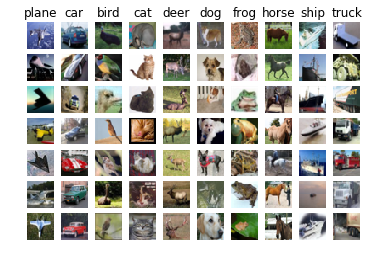

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


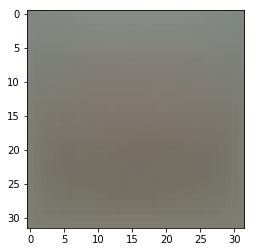

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.131331


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -45.307421 analytic: -45.307421, relative error: 9.482780e-12
numerical: -2.217311 analytic: -2.196016, relative error: 4.825156e-03
numerical: -7.111886 analytic: -7.111886, relative error: 9.455219e-11
numerical: 13.504534 analytic: 13.469466, relative error: 1.300062e-03
numerical: 14.718389 analytic: 14.718389, relative error: 1.163901e-11
numerical: 35.917725 analytic: 35.917725, relative error: 7.607760e-12
numerical: -6.478196 analytic: -6.478196, relative error: 1.244242e-11
numerical: -5.413147 analytic: -5.359497, relative error: 4.980203e-03
numerical: 9.391927 analytic: 9.391927, relative error: 5.455720e-11
numerical: -3.567260 analytic: -3.567260, relative error: 3.179556e-11
numerical: -62.303097 analytic: -62.303097, relative error: 9.387707e-13
numerical: -7.639108 analytic: -7.639108, relative error: 2.104322e-11
numerical: 30.353096 analytic: 30.380138, relative error: 4.452655e-04
numerical: 15.209269 analytic: 15.213828, relative error: 1.498263e-04
nume

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$

1. A max() or min() function
2. I think by "is it a reason for concern?" the writer of this question was trying to ask "Did we calculate the gradient wrong?  Is our gradient wrong because the numerical gradient is not equal to the analytic gradient?"  The answer is no.  A piecewise-function can be hard to differentiate-across at boundaries, but it doesn't matter as long as the classifier "learns" the right thing and ends up making good predictions at the end of the day.  And over many training examples, our SVM will learn what it needs to learn; how to classify different images into different classes
3. An example of "a simple example in one dimension where a gradient check could fail" is f=max(0,x).  Around 0, if the step "h" used to calculate the numerical gradient is bigger than the current value of x (ie. x=-0.1 and h=0.2), we'll get a different answer; analytical gradient f'(-0.1) == 0, but (max(0, 0.1)- max(0, -0.1)) / 0.2 == 0.5.  
4. I don't think it would, except maybe in specific cases.  The weights would just gather around values that predicted the right answers with higher confidence over the baseline

In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_naive # on Sat Jun 22 16:22:23 UTC 2019,  nxBendich added this line
#why?  it "refreshes" the naive import
from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.131331e+00 computed in 0.157127s
Vectorized loss: 9.131331e+00 computed in 0.011771s
difference: 0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

from cs231n.classifiers.linear_svm import svm_loss_naive

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.157862s
Vectorized loss and gradient: computed in 0.010745s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [11]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 784.010340
iteration 100 / 1500: loss 286.494615
iteration 200 / 1500: loss 108.075861
iteration 300 / 1500: loss 42.761744
iteration 400 / 1500: loss 18.696754
iteration 500 / 1500: loss 10.291154
iteration 600 / 1500: loss 7.213358
iteration 700 / 1500: loss 5.384925
iteration 800 / 1500: loss 5.820231
iteration 900 / 1500: loss 5.397771
iteration 1000 / 1500: loss 4.969580
iteration 1100 / 1500: loss 5.075741
iteration 1200 / 1500: loss 5.617465
iteration 1300 / 1500: loss 5.565645
iteration 1400 / 1500: loss 4.961563
That took 6.374569s


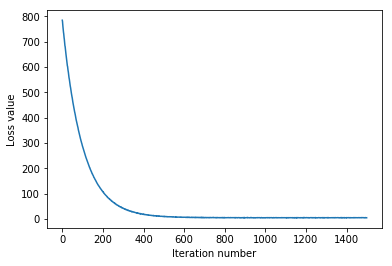

In [12]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368204
validation accuracy: 0.375000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.


#Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# lr 
learning_rates = [5e-8]  # np.linspace(1e-8, 1.5e-7, 20) #1e-5, 4) #5e-5, 10)# [1e-7, 5e-5]
#reg should probably be lower than 2.5e4
regularization_strengths = [1.5e4]  # np.linspace(1e4, 5e4, 20) #[2.5e4]  #[2.5e4, 5e4]

N_iters = np.linspace(1000,2500,20)    # if we were doing this for real, I'd want to double-triple check every possible "hyperparameter"

for lr in learning_rates:
    for reg in regularization_strengths:
        for N in N_iters:
            # Initialize:
            svm=LinearSVM()

            # Train:
            _ = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                            num_iters= 1500, #400,   # 400 gave us ~ 0.35 acc;  0.35 is definitely underfitting??
                            verbose=False) #True)
            # num_iters is also a hyperparameter???

            # Predict:
            y_train_pred = svm.predict(X_train)
            train_acc    = np.mean(y_train_pred == y_train)
            y_val_pred   = svm.predict(X_val)
            val_acc      = np.mean(y_val_pred == y_val)

            # Save best:
            if val_acc > best_val:
                best_val= val_acc
                best_svm = svm

            # Save all:
            results[(lr, reg)] = (train_acc, val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-08 reg 1.500000e+04 train accuracy: 0.374653 val accuracy: 0.385000
best validation accuracy achieved during cross-validation: 0.391000


In [19]:
results

{(5e-08, 15000.0): (0.37465306122448977, 0.385)}

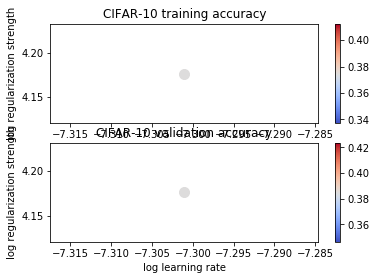

In [15]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.368000


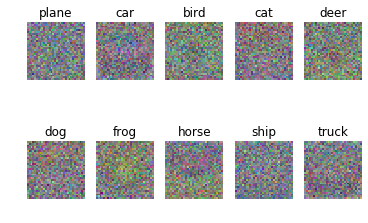

In [17]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ 
They're pretty ugly.  It's hard to be 100% certain why they look this way.  It's now much clearer to me why you need a deep NN/CNN to classify images; this simple template doesn't even come close to explaining how an animal looks.  For one, color has *almost* nothing to do with what makes an object a member of its class.  Any kid can imagine a blue dog, even though there aren't *really* blue dogs wandering around the world (at least, to the best of *my* knowledge; we haven't been to exoplanets yet).

To the question, you can see a few things;

1. Cars: the template looks like a red car facing "towards" the camera.  (windshield towards us)  Maybe the cars in the CIFAR-10 dataset are a purplish reddish color (maybe some black ones, some blue ones, and some bright red; the black might be making it look purple), and they're mostly facing "forward" where their windshield is facing the viewer (ie. I don't think we see the side doors or the trunk in most of them)  After looking at some actual CIFAR-10 images [here](https://www.cs.toronto.edu/~kriz/cifar.html), I'm not sure where the purplish reddish color comes from.  There don't seem to be many blue cars in CIFAR-10 from the subsampling on that webpage

2. Frog: the frogs are mostly green, though there I see many brown ones in the subsample of CIFAR-10 found [here](https://www.cs.toronto.edu/~kriz/cifar.html).  Maybe they have red eyes?  (my interpretation of the yellow blob near top of img frame)
3. Horse: There are horses facing "both" directions (left and right), but prob not many facing directly towards or directly away from the camera.
4. Deer: mostly in green backgrounds (outside, in meadows, etc.).  sky looks blue
5. Ship: blue background, maybe grey hull?  Or half the ships in CIFAR-10 are black and the other half are white
6. Cat: strangely purple background where the "ground" should be
7. Plane: blue skies
8. Dog: brown blob near the top of the 32x32 frame.  Is this blob the dog's body?  After looking at the actual CIFAR-10 images, it's clear that dog color is pretty varied.  At least, it is between brown, black and white
9. Truck:  Sky in the top section.  Maybe facing forward?  Hard to tell.  After looking at the actual CIFAR-10 images, I realized trucks are also (like birds) extremely varied in color.  
10. Bird: green/cyan blobs where the wings are.  After looking at actual CIFAR-10 images, I realized "bird" is an extremely general "class" that includes ostriches, chickens, and other large birds, as well as the usual tiny birds (ie. sparrows, robins) I mostly think of when I hear the word "bird."  I'm still not sure why there are those bright gren blobs off-center.  Maybe because there's sometimes bright whitish-blue sky in the background and other times green in the background

#### Note: all these explanations became a lot more sensible and less "guesswork-y" after I actually pulled out the CIFAR-10 images and looked at them


# Results:
##### training   accuracy: 0.370204
##### validation accuracy: 0.381000

##### KNN maxed out at (roughly) 0.3000 for 5-NN:
